In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [52]:

# Step 1: Load and Preprocess Data
# Define the folder path where your CSV files are located
folder_path = "/content/folder"  # Update this to your folder path

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]


In [53]:
# Read all CSV files and combine them into a single DataFrame
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all dataframes
combined_df = pd.concat(df_list, ignore_index=True)

In [54]:
# Ensure 'timestamp' is in datetime format
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Sort by timestamp
combined_df.sort_values('timestamp', inplace=True)

# Reset index after sorting
combined_df.reset_index(drop=True, inplace=True)

# Handle missing values by forward filling
combined_df.fillna(method='ffill', inplace=True)

<ipython-input-54-d9f28dca3aa8>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='ffill', inplace=True)


In [55]:
# Normalize the 'value' column
scaler = MinMaxScaler()
combined_df['value_normalized'] = scaler.fit_transform(combined_df[['value']])

# Step 2: Anomaly Detection using Isolation Forest
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(combined_df[['value_normalized']])

IsolationForest(contamination=0.01, random_state=42)

In [56]:
# Predict anomalies
combined_df['anomaly_score'] = iso_forest.predict(combined_df[['value_normalized']])

# Mark anomalies where the model assigns -1 as the score
combined_df['anomaly'] = combined_df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

In [57]:
# Step 3: Anomaly Categorization
# Calculate rolling mean and difference
window_size = 10  # Adjust window size as needed
combined_df['rolling_mean'] = combined_df['value'].rolling(window=window_size).mean()
combined_df['difference'] = combined_df['value'] - combined_df['rolling_mean']

# Handle NaN values resulting from rolling calculation
combined_df['rolling_mean'].fillna(method='bfill', inplace=True)
combined_df['difference'].fillna(0, inplace=True)

# Define thresholds based on quantiles
threshold_spike = combined_df['difference'].quantile(0.95)
threshold_drop = combined_df['difference'].quantile(0.05)

<ipython-input-57-fb0e869b7fc7>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['rolling_mean'].fillna(method='bfill', inplace=True)


In [58]:
# Function to categorize anomalies
def categorize_anomaly(row):
    if row['anomaly'] == 1:
        if row['difference'] > threshold_spike:
            return 'spike'
        elif row['difference'] < threshold_drop:
            return 'drop'
        else:
            return 'drift'
    return 'normal'

# Apply categorization
combined_df['anomaly_category'] = combined_df.apply(categorize_anomaly, axis=1)


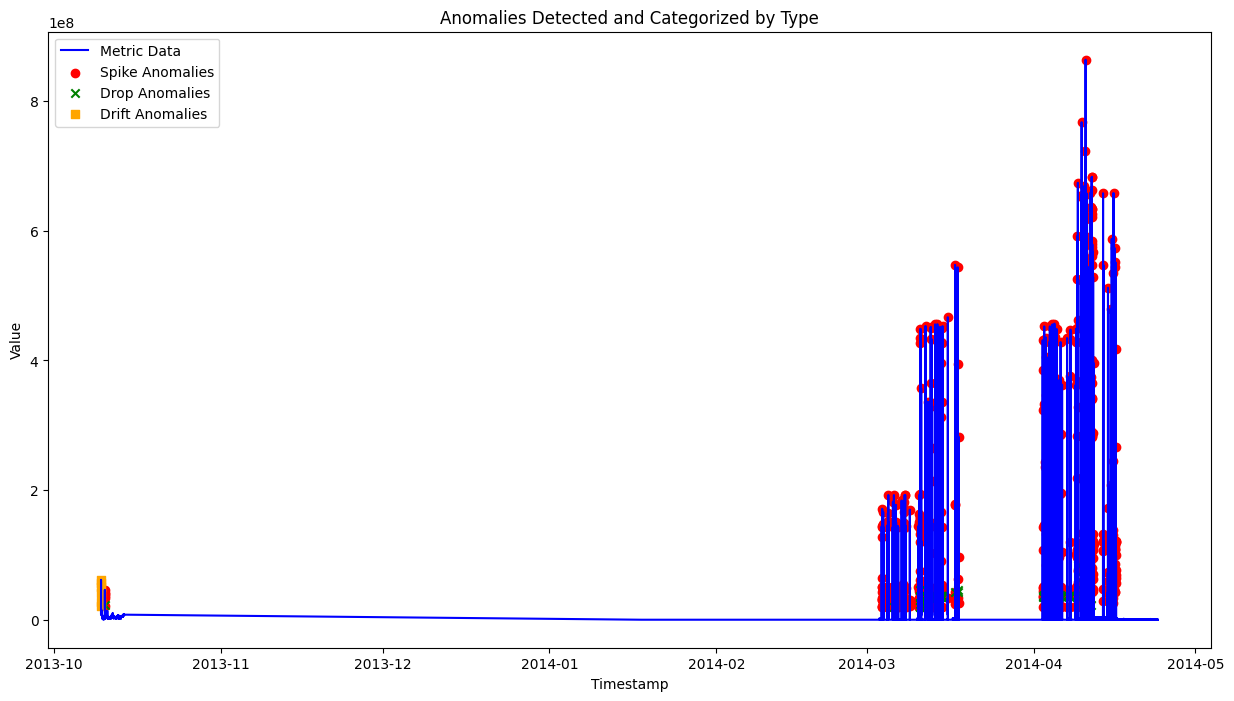

In [59]:
# Step 4: Calculate Severity Score
# Calculate the maximum absolute deviation
max_deviation = combined_df['difference'].abs().max()

# Calculate severity score
combined_df['severity_score'] = combined_df['difference'].abs() / max_deviation

# Step 5: Visualization
# Plot the time series data with anomalies highlighted
plt.figure(figsize=(15, 8))

# Plot the 'value' against 'timestamp'
plt.plot(combined_df['timestamp'], combined_df['value'], label='Metric Data', color='blue')

# Plot anomalies categorized by type
categories = ['spike', 'drop', 'drift']
colors = ['red', 'green', 'orange']
markers = ['o', 'x', 's']

for category, color, marker in zip(categories, colors, markers):
    subset = combined_df[combined_df['anomaly_category'] == category]
    plt.scatter(subset['timestamp'], subset['value'], color=color, label=f'{category.capitalize()} Anomalies', marker=marker)

# Adding title and labels
plt.title('Anomalies Detected and Categorized by Type')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [62]:
# Step 6: Precision, Recall, and F1 Score Calculation
# Check if 'actual_anomaly' column exists
if 'actual_anomaly' in combined_df.columns:
    # Ensure actual_anomaly is binary (0 or 1)
    combined_df['actual_anomaly'] = combined_df['actual_anomaly'].apply(lambda x: 1 if x == 1 else 0)

    # Calculate Precision, Recall, and F1 Score
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix #Import the necessary modules

    precision = precision_score(combined_df['actual_anomaly'], combined_df['anomaly'])
    recall = recall_score(combined_df['actual_anomaly'], combined_df['anomaly'])
    f1 = f1_score(combined_df['actual_anomaly'], combined_df['anomaly'])

    # Print the results
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(combined_df['actual_anomaly'], combined_df['anomaly'])
    print("Confusion Matrix:")
    print(conf_matrix)
else:
    print("Ground truth labels ('actual_anomaly' column) not found. Skipping evaluation metrics.")

# Optional: Display the first few rows of the final DataFrame
combined_df.head()

Ground truth labels ('actual_anomaly' column) not found. Skipping evaluation metrics.


,timestamp,value,value_normalized,anomaly_score,anomaly,rolling_mean,difference,anomaly_category,severity_score
0,2013-10-09 16:25:00,9926554.0,0.011490,1,0,31807531.02,0.0,normal,0.0
1,2013-10-09 16:30:00,50745578.0,0.058736,-1,1,31807531.02,0.0,drift,0.0
2,2013-10-09 16:35:00,61519397.0,0.071206,-1,1,31807531.02,0.0,drift,0.0
3,2013-10-09 16:40:00,55996401.0,0.064813,-1,1,31807531.02,0.0,drift,0.0
4,2013-10-09 16:45:00,40876988.0,0.047313,-1,1,31807531.02,0.0,drift,0.0
